У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.
Данные
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:
    • data_train.csv: id, vas_id, buy_time, target
    • features.csv.zip: id, <feature_list> 

И тестовый набор:
    • data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.
Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

Формат представления результата
    1. Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
    2. Код модели можно представить в виде jupyter-ноутбука. 
    3. Презентация в формате .pdf, в которой необходимо отразить:
        ◦ Информация о модели, ее параметрах, особенностях и основных результатах.
        ◦ Обоснование выбора модели и ее сравнение с альтернативами.
        ◦ Принцип составления индивидуальных предложений для выбранных абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

In [1]:
import pandas as pd
import numpy as np
import itertools
import gc
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

import seaborn as sns

from scipy.stats import boxcox, probplot
import matplotlib.pyplot as plt
import matplotlib as mplt
#%matplotlib inline

# убираем лишние замечания интерпретатора
import warnings
warnings.simplefilter('ignore')

# import additional packages for WOE/IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
# глобальные переменные WOE/IV
max_bin = 20
force_bin = 3

import gc
pd.options.display.max_columns = 250

In [2]:
# функции метода WOE/IV

def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

### EDA
#### 1) загрузка и корреляция

In [11]:
# loading data
data_train = pd.read_csv('./data_train.csv')
data_test = pd.read_csv('./data_test.csv')

In [13]:
# check correlation between all features in data_train
data_train.corr()

Unnamed: 0        id    vas_id  buy_time    target
Unnamed: 0    1.000000  0.004192 -0.035868  0.091984  0.010123
id            0.004192  1.000000 -0.015383 -0.012761 -0.061788
vas_id       -0.035868 -0.015383  1.000000  0.254246  0.263024
buy_time      0.091984 -0.012761  0.254246  1.000000  0.143306
target        0.010123 -0.061788  0.263024  0.143306  1.000000

Вывод: есть небольшая корреляция между временем потребления услуги и типом услуги - скорее всего, это связано с суточным циклом потребления услуг, а также очень слабая корреляция между абонентом и целью.

In [54]:
# delete unused 'Unnamed: 0'
data_train_ = data_train.drop(['Unnamed: 0'], axis = 1)
data_test_ = data_train.drop(['Unnamed: 0'], axis = 1)

#### 2) тестовый прогон предсказания потребления услуги абонентом

In [14]:
X = data_train.drop(['Unnamed: 0'],axis=1)
y = data_train['target']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['target'],axis=1), y, test_size=0.2, random_state=42, shuffle=True)

In [16]:
scaler = StandardScaler()

In [17]:
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test) # fit не нужен, т.к. среднее и ско вычислили на предыдущей строчке

0.0    0.927718
1.0    0.072282
Name: target, dtype: float64

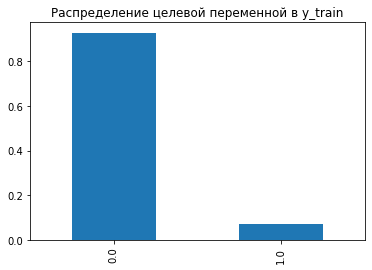

In [18]:
(y_train.value_counts()/y_train.shape[0]).plot(kind='bar', title='Распределение целевой переменной в y_train');
y_train.value_counts()/y_train.shape

0.0    0.927284
1.0    0.072716
Name: target, dtype: float64

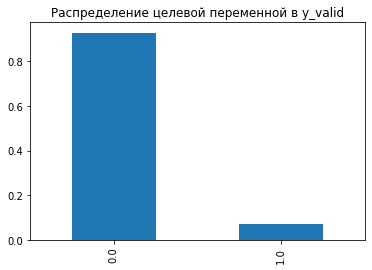

In [19]:
(y_test.value_counts()/y_test.shape[0]).plot(kind='bar', title='Распределение целевой переменной в y_valid');
y_test.value_counts()/y_test.shape

распределение очень близко друг к другу

In [20]:
# задаём функцию обучения модели классификации, с выводом 3-х метрик
def train_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).astype(int)
    
    print("f1_score: {}".format(f1_score((y_test), (y_pred))))
    print("precision: {}".format(precision_score((y_test), (y_pred))))
    print("recall: {}".format(recall_score((y_test), (y_pred))))

In [21]:
logreg = LogisticRegression()

In [22]:
train_model(logreg, X_train_scale, y_train, X_test_scale, y_test)

f1_score: 0.013408723747980612
precision: 0.2912280701754386
recall: 0.006862339809838776


In [23]:
rfc = RandomForestClassifier(n_estimators=55, criterion='gini', random_state=0)

In [26]:
train_model(rfc, X_train_scale, y_train, X_test_scale, y_test)

f1_score: 0.4126185082641161
precision: 0.41880269096483014
recall: 0.4066143034311699


In [29]:
y_pred = rfc.predict(X_test_scale).astype(int)
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    154236
         1.0       0.42      0.41      0.41     12095

    accuracy                           0.92    166331
   macro avg       0.69      0.68      0.68    166331
weighted avg       0.91      0.92      0.92    166331



Вывод: плохое предсказание потребления услуги и отличное предсказание непотребления услуги. Слабая классификация

### Загрузка и обработка таблицы основных признаков.

In [4]:
features = pd.read_csv('./features.csv', sep = '\t')

In [5]:
features.shape

(4512528, 256)

Черезчур огромная таблица, нужно резать на куски и обрабатывать по-кусочно, делим да 10 кусков

In [10]:
for i in range(1,11):
    features_frac = features[((i-1) * int(features.shape[0]/10)):(i * int(features.shape[0]/10))]
    with open('f' + str(i) + '.pkl', 'wb') as file:
        pickle.dump(features_frac, file)
    del features_frac
    gc.collect()

In [75]:
# теперь можно удалить большой датафрейм и работать по-кусочно
del features
gc.collect()

1345

In [95]:
# объединение DFs: загружаем кусок, обрабатываем столбцы, объединяем, обрабатываем столбцы, сохраняем кусок
# создаём пустой датафрейм, объединяем пустой дф с куском на каждой итерации, получаем итоговый дф 
for i in range(1,10):
    with open('f' + str(i) + '.pkl', 'rb') as file:
        features_frac = pickle.load(file)
    features_frac_ = features_frac.drop(['Unnamed: 0'], axis = 1) # to delete unused column
    features_frac = features_frac_.rename(columns = {'id' : 'subs'}) # to rename columns for misunderstanding
    data_train = data_train_.rename(columns = {'id' : 'subs'}) # to rename columns for misunderstanding
    X = pd.merge(data_train, features_frac, on=['subs'], how='inner') # to merge the DFs
    X_ = X[X['buy_time_x'] == X['buy_time_y']] # to keep just wit same timestamp
    X = X_.drop(['buy_time_y'], axis =1) # to delete unused column
    X = X.rename(columns = {'buy_time_x' : 'buy_time', 'subs' : 'id'}) # to rename columns in order to come back
    with open('X_train.pkl', 'wb') as file:
        pickle.dump(X_train, file)

In [252]:
with open('X1.pkl', 'rb') as file:
        data = pickle.load(file)
for i in range(2,10):
    with open('X' + str(i) + '.pkl', 'rb') as file:
        X = pickle.load(file)
    data = pd.concat([data, X], axis = 0)

In [253]:
data

id  vas_id    buy_time  target          0           1           2  \
13     1631111     7.0  1544994000     0.0 -52.559971  338.760888  -63.960786   
46     4130556     1.0  1532898000     0.0 -82.399971 -137.419112  -96.340786   
67     4088280     2.0  1534712400     0.0 -96.799971 -408.179112 -110.740786   
77     4341324     1.0  1534712400     0.0 -89.169971 -377.639112 -103.110786   
137     899130     5.0  1534107600     0.0 -47.599971 -186.779112  -61.540786   
...        ...     ...         ...     ...        ...         ...         ...   
85716  1542422     5.0  1545598800     0.0  72.210029  494.280888   67.159214   
85740  2806088     5.0  1546203600     0.0 -96.799971 -194.789112 -108.200786   
85745  4214425     2.0  1544994000     0.0 -45.599971  160.150888   25.629214   
85778   225749     7.0  1545598800     0.0 -43.619971 -227.269112  -57.560786   
85798  1759327     2.0  1546203600     0.0 -54.279971 -222.919112  -64.050786   

                3           4          5         6          7         8  \
13     371.743202  -51.048246  379.65821 -16.08618 -65.076097 -6.783660   
46    -185.786798 -101.758246 -206.89179  -1.68618 -50.676097  7.616340   
67    -460.786798 -116.158246 -481.89179 -16.08618 -65.076097 -6.783660   
77    -430.246798 -108.528246 -451.35179 -16.08618 -65.076097 -6.783660   
137   -239.386798  -66.958246 -260.49179 -16.08618 -65.076097 -6.783660   
...           ...         ...        ...       ...        ...       ...   
85716  490.373202   61.741754  469.26821 -16.08618  16.283903 -6.783660   
85740 -244.856798 -113.618246 -261.38179 -16.08618 -65.076097 -6.783660   
85745  231.253202   20.211754  210.14821 -10.15618 -59.146097 -6.508189   
85778 -249.376798   -3.688246  -33.32179  25.49382  87.383903 -1.867621   
85798 -271.356798  -69.468246 -292.46179 -16.08618 -65.076097 -6.783660   

               9        10         11        12         13        14  \
13    -30.006538 -2.736081  -4.007526 -2.558912 -66.189127 -74.46811   
46    -15.606538 -2.736081  -4.007526 -2.558912 -66.189127 -77.51811   
67    -30.006538 -2.736081  -4.007526 -2.558912 -66.189127 -77.51811   
77    -30.006538 -2.736081  -4.007526 -2.558912 -66.189127 -77.51811   
137   -30.006538 -2.736081  -4.007526 -2.558912 -16.989127 -28.31811   
...          ...       ...        ...       ...        ...       ...   
85716  51.353462 -2.736081  -4.007526 -2.558912 -66.189127  79.26189   
85740 -30.006538 -2.736081  -4.007526 -2.558912 -66.189127 -77.51811   
85745 -29.731067 -2.736081   1.647002 -2.558912 -66.189127 -61.24811   
85778  -1.270799 -2.736081  23.416436  6.681088 -66.189127 -65.91811   
85798 -30.006538 -2.736081  -4.007526 -2.558912 -66.189127 -34.99811   

             15        16        17        18         19         20  \
13    -0.000725 -0.016435 -0.107041  12.91254  38.011479 -11.400815   
46    -0.000725 -0.016435 -0.107041  -5.41746  -3.178521 -13.940815   
67    -0.000725 -0.016435 -0.107041  -5.41746  -3.178521 -13.940815   
77    -0.000725 -0.016435 -0.107041  -5.41746   4.451479 -13.940815   
137   -0.000725 -0.016435 -0.107041  -5.41746  -3.178521 -13.940815   
...         ...       ...       ...       ...        ...        ...   
85716 -0.000725 -0.016435 -0.107041  -5.41746   9.051479  -5.050815   
85740 -0.000725 -0.016435 -0.107041  -5.41746  -3.178521 -11.400815   
85745 -0.000725 -0.016435 -0.107041  -5.41746  25.821479  71.229185   
85778 -0.000725 -0.016435 -0.107041  53.87254  -3.178521 -13.940815   
85798 -0.000725 -0.016435 -0.107041  -5.41746  -3.178521  -9.770815   

              21         22        23        24         25        26       27  \
13    -10.744164  -0.094251 -0.001733 -0.009327  63.547791  0.200138 -0.00909   
46     -8.204164  -0.094251 -0.001733 -0.009327  -2.082209  0.200138 -0.00909   
67    -10.744164  -0.094251 -0.001733 -0.009327  -2.082209 -0.799862 -0.00909   
77    -10.744164  -0.094251 -0.001733 -0.009327   5.547791  0.200138 -0.00909   
137   -10.74416

In [254]:
y = data['target']

0.0    0.93186
1.0    0.06814
Name: target, dtype: float64

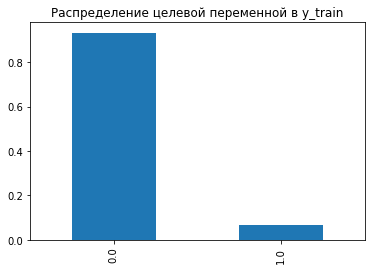

In [255]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной в y_train');
y.value_counts()/y.shape

Вывод: распределение более-менее совпадает с файлом data_train

In [199]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'],axis=1), y, test_size=0.2, random_state=42, shuffle=True)

In [200]:
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test) # fit не нужен, т.к. среднее и ско вычислили на предыдущей строчке

In [201]:
train_model(rfc, X_train_scale, y_train, X_test_scale, y_test)

f1_score: 0.04651162790697675
precision: 0.65
recall: 0.02411873840445269


Очень маленький recall, продолжаем анализировать данные

In [202]:
data_corr = data.corr()

<AxesSubplot:>

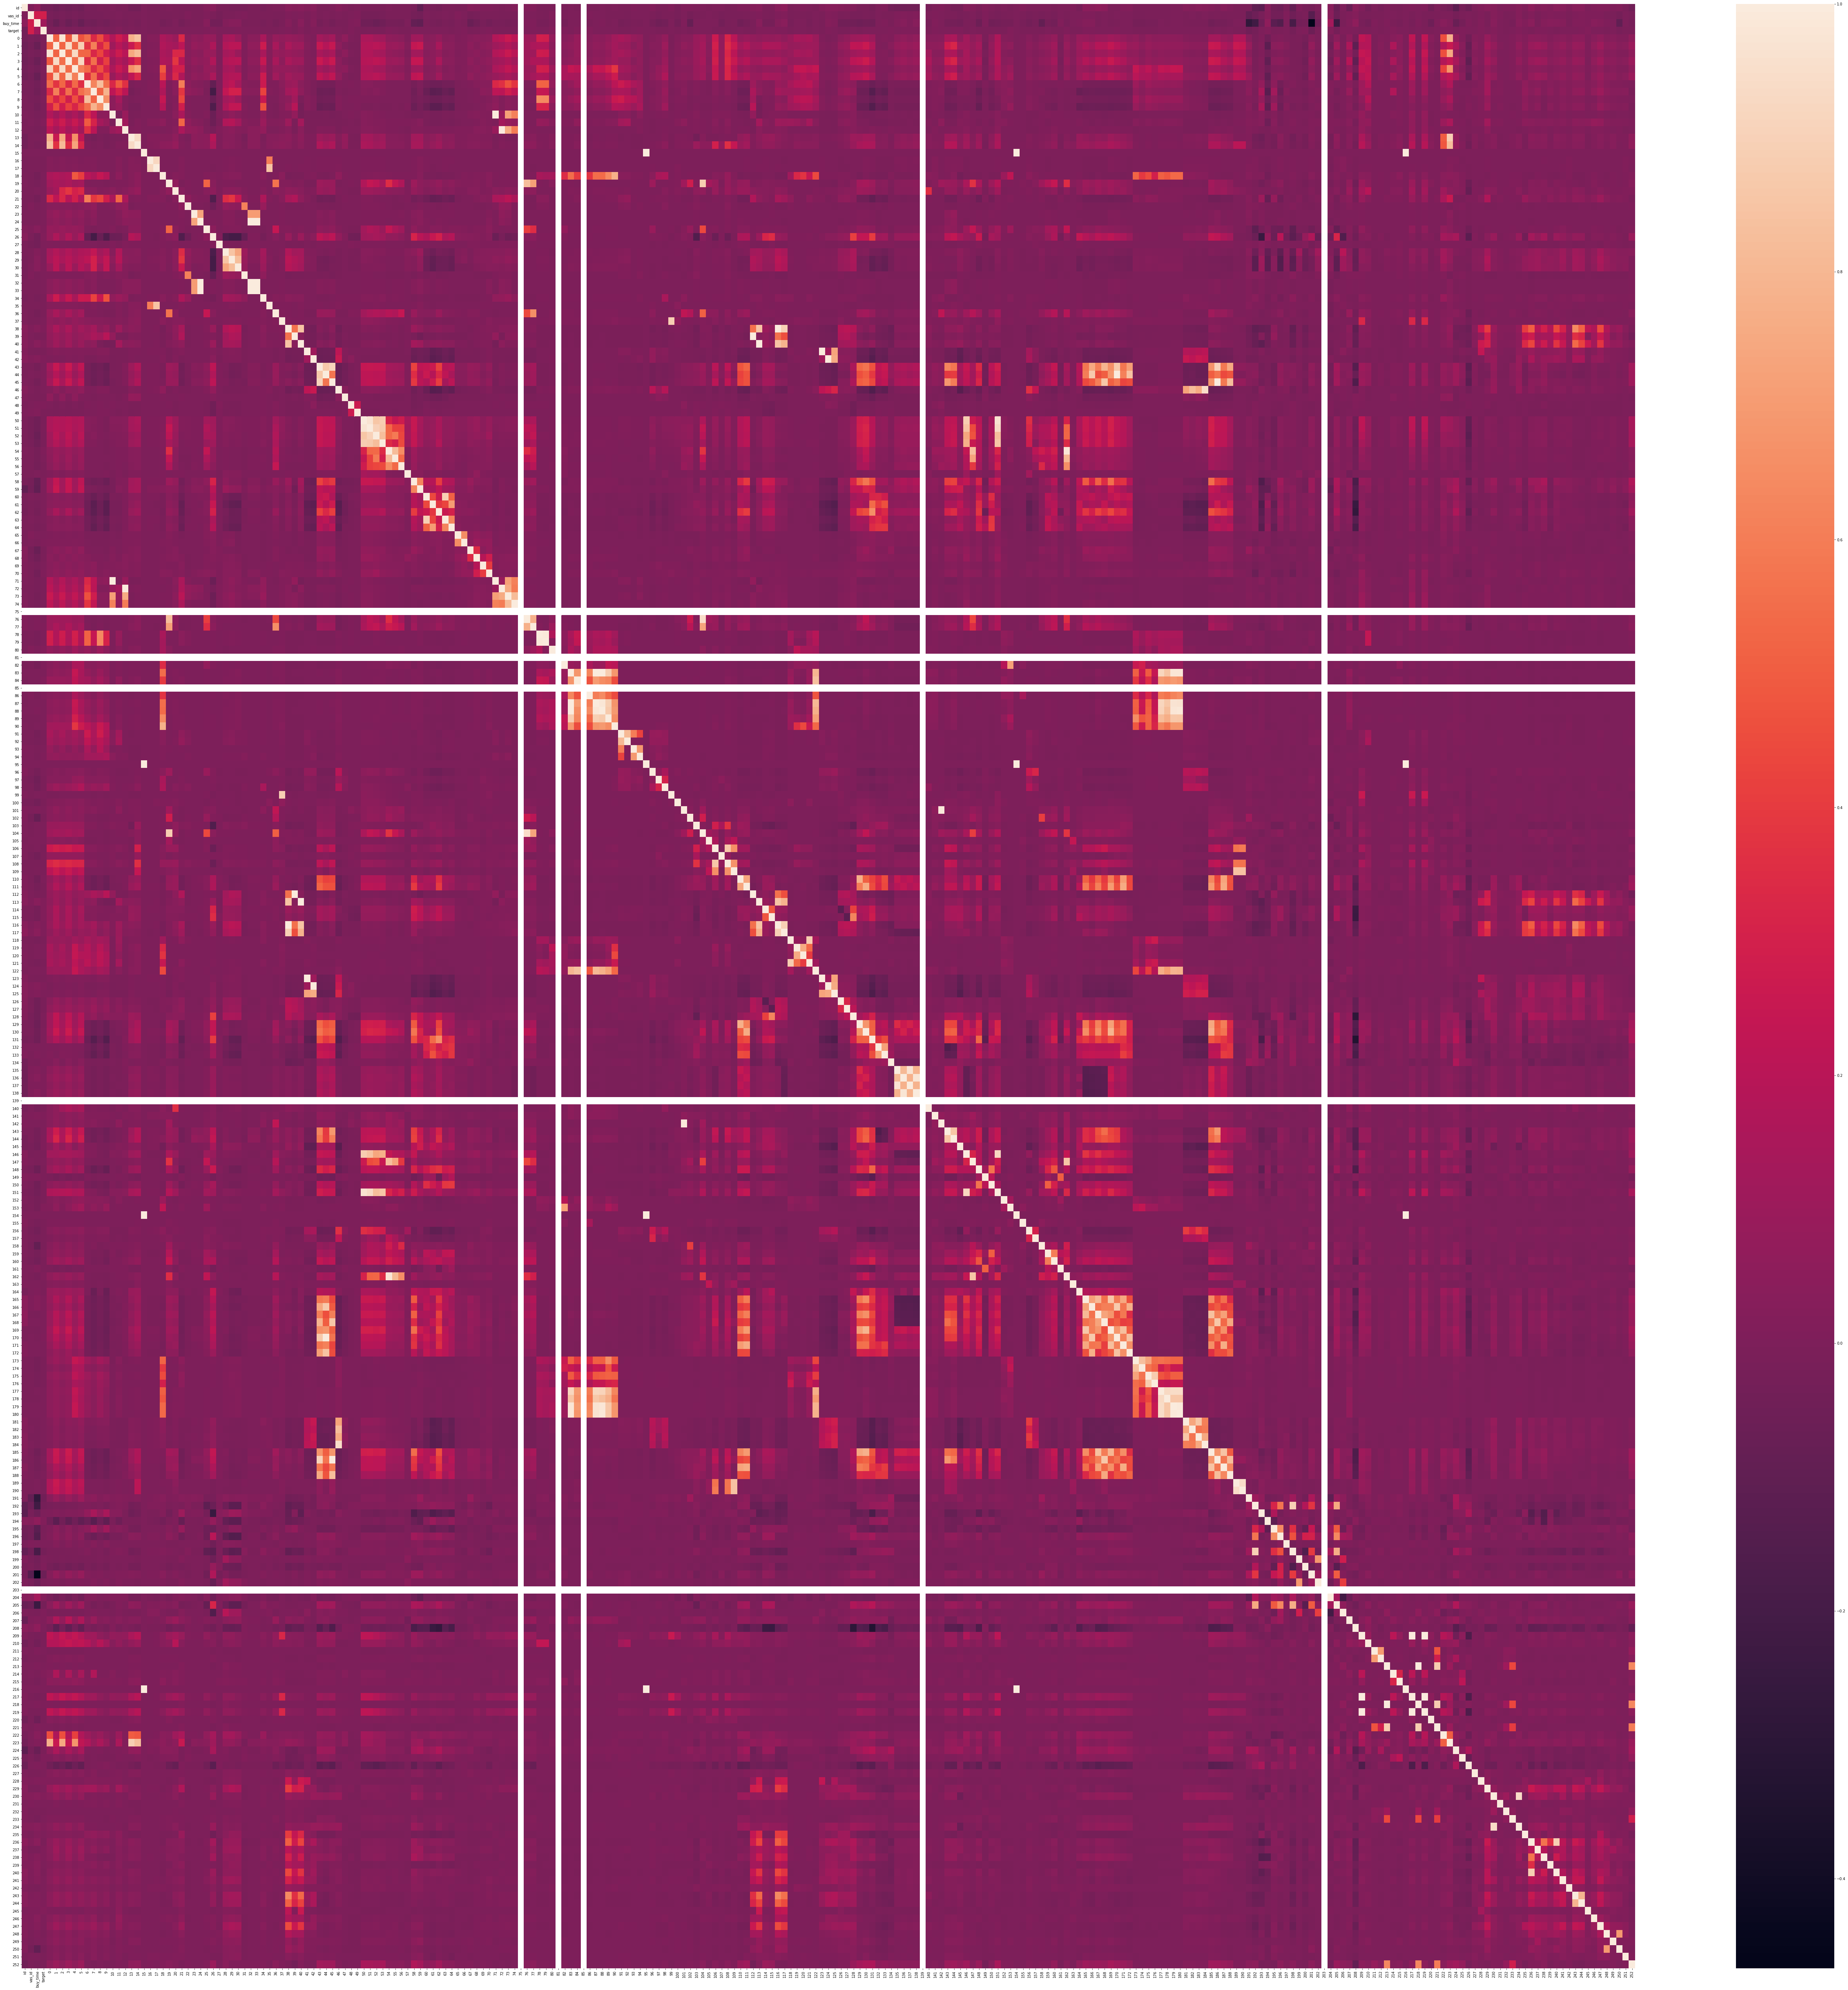

In [203]:
plt, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(data_corr,ax=ax)

In [204]:
data.columns

Index(['id', 'vas_id', 'buy_time', 'target', '0', '1', '2', '3', '4', '5',
       ...
       '243', '244', '245', '246', '247', '248', '249', '250', '251', '252'],
      dtype='object', length=257)

In [256]:
# определяем список (в виде множества) всех фич и вычисляем их количество
f_all = set(data.columns.tolist())
len(f_all)

257

In [258]:
# вычисляем количество уникальных значений во всех фичах и помещаем в Series
features_nunique = data.apply(lambda data: data.nunique(dropna=False))
pd.DataFrame(features_nunique).T

id  vas_id  buy_time  target     0      1     2      3      4      5  \
0  34933       8        26       2  7698  17716  9925  20999  10231  21494   

      6     7     8     9   10    11   12    13    14  15  16  17   18   19  \
0  1083  2770  2087  4180  409  1855  285  1757  5093   1   3   6  687  927   

     20   21  22  23  24   25  26  27  28  29  30  31  32  33   34  35   36  \
0  1880  636  43   2   3  631   2   2  12   6   6   2   2   2  388   5  345   

     37     38     39     40    41    42     43     44     45    46     47  \
0  2013  27165  24479  19421  2181  1387  18747  14054  14853  2762  16607   

     48    49   50   51   52   53   54   55   56  57   58  59   60   61  62  \
0  4392  9292  408  492  618  337  219  297  124   2  277  76  101  100  54   

    63   64  65   66  67    68  69  70   71   72   73   74  75    76    77  \
0  100  100   5  268  61  1161  10  13  416  290  572  468   1  1009  2598   

   78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  \
0  39  37  11   1  65  26  10   1  12  22  15  74  73  83  68  28  81   1   

    96  97   98   99  100  101  102   103   104  105   106  107   108  109  \
0  183  93  242  829  194   52  200  1286  1163   32  2613   71  3007  138   

   110  111    112    113  114  115    116    117  118  119  120  ...  128  \
0   42   83  24726  19444  101  101  27238  23213  102   30   76  ...  101   

   129  130  131  132  133   134  135  136  137  138  139  140  141  142  \
0   68  155    6    2   11  1283   47  108   40   79    1  152   11   21   

     143    144  145  146  147  148  149  150  151  152  153  154  155  156  \
0  11147  18613   83  366  198   81   49  101  397   70   22    1    6  189   

   157  158  159  160  161  162  163  164  165    166  167    168  169    170  \
0   68   83   99   76   38  217   18  100  253  13223  307  13931  258  14859   

   171    172  173  174  175  176  177  178  179  180  181   182  183   184  \
0  181  11370   23  161   19  119   10   29    8   18  115  2095  162  2312   

   185    186  187    188  189  190   191  192  193  194  195  196  197  198  \
0  317  15787  225  12158   28  196  9911    2   11    2    2    2    2    2   

   199  200  201  202  203  204  205  206    207   208  209   210   211  212  \
0    2    2    2    2    1    2    2    2  21894  6768   35  5100  5441    4   

   213  214  215  216  217  218  219  220  221  222  223   224   225   226  \
0  918   15   25    1   35    2   35    5    4  186  685  7858  2858  2400   

   227  228   229  230  231  232  233  234  235   236  237   238   239   240  \
0  148  417  2375  833   62   45   51  796  614  5119  170  2774  1677  3831   

    241  242   243   244  245  246   247  248  249  250  251  252  
0  1527  664  5081  4042  483  893  2368  552   93  373   81    5  

[1 rows x 257 columns]

#### константные признаки

In [259]:
# помести все фичи с константными значениями в множество и вычислим их колво
f_const = set(features_nunique[features_nunique == 1].index.tolist())
len(f_const)

9

#### категориальные признаки

In [260]:
# сохраняем категориальные фичи в списке и выдаём их количество
f_cat = data.select_dtypes(include=['object']).columns.to_list()
len(f_cat)

0

#### Выявление дискретных признаков

In [262]:
#считаем дискретными фичи с количеством значений менее или равно 25 и загоняем их в множество, выдаём их кол-во.
f_discrete = set(features_nunique[features_nunique <= 25].index.tolist())
f_discrete = f_discrete - f_const
len(f_discrete)

59

###### Непрерывные признаки

In [263]:
f_cont = f_all - f_discrete - f_const
len(f_cont)

189

In [264]:
# checking amounts of features
if len(f_all) == len(f_cont) + len(f_discrete) + len(f_const) + len(f_cat):
    print("it's Ok")

it's Ok


In [265]:
# удалим мусор из памяти
gc.collect()

2801

### Обработаем выбросы:

#### удалим 1 процент сверху и снизу во всех фичах
for i in range(253):
    q = np.quantile(data[str(i)], q=0.99);
    data.loc[data[str(i)] > q, [str(i)]] = data[str(i)].median()
    q = np.quantile(data[str(i)], q=0.01);
    data.loc[data[str(i)] < q, [str(i)]] = data[str(i)].median()

In [275]:
# теперь удалим константные - мусорные фичи:
data_ = data.drop(f_const, axis=1)

In [276]:
data_.shape

(34943, 248)

In [277]:
data_ = data_.sort_values(by = 'id')

In [278]:
data_ = data_.reset_index(drop=True)
data_.head()

id  vas_id    buy_time  target          0           1           2  \
0    2     2.0  1545598800     0.0 -96.799971  229.530888 -110.740786   
1  389     2.0  1544994000     0.0 -84.079971   94.350888  -85.310786   
2  620     1.0  1537736400     0.0 -64.099971 -320.009112  -78.040786   
3  633     2.0  1544994000     0.0 -95.269971 -332.789112 -104.970786   
4  665     6.0  1543179600     1.0 -96.799971 -408.179112 -110.740786   

            3           4          5         6          7        8          9  \
0  305.723202 -116.158246  284.61821 -16.08618 -65.076097 -6.78366 -30.006538   
1   58.693202  -90.728246   37.58821  -3.36618  15.483903 -6.70814 -25.810938   
2 -372.616798  -83.458246 -393.72179 -16.08618 -65.076097 -6.78366 -30.006538   
3 -359.966798 -110.388246 -381.07179 -16.08618 -65.076097 -6.78366 -30.006538   
4 -460.786798 -116.158246 -481.89179 -16.08618 -65.076097 -6.78366 -30.006538   

         10        11        12         13        14        16        17  \
0 -2.736081 -4.007526 -2.558912 -66.189127 -77.51811 -0.016435 -0.107041   
1 -2.736081  8.636954 -2.558912 -66.189127 -77.51811 -0.016435 -0.107041   
2 -2.736081 -4.007526 -2.558912 -48.409127 -44.81811 -0.016435 -0.107041   
3 -2.736081 -4.007526 -2.558912 -66.189127 -75.98811 -0.016435 -0.107041   
4 -2.736081 -4.007526 -2.558912 -66.189127 -77.51811 -0.016435 -0.107041   

        18        19         20         21        22        23        24  \
0 -5.41746 -3.178521 -13.940815 -10.744164 -0.094251 -0.001733 -0.009327   
1 -5.41746 -3.178521  -1.230815 -10.744164 -0.094251 -0.001733 -0.009327   
2 -5.41746 -3.178521 -13.940815 -10.744164 -0.094251 -0.001733 -0.009327   
3 -5.41746 -3.178521  -9.700815 -10.744164 -0.094251 -0.001733 -0.009327   
4 -5.41746 -3.178521 -13.940815 -10.744164 -0.094251 -0.001733 -0.009327   

         25        26       27        28        29        30        31  \
0 -2.082209  0.200138 -0.00909 -0.351862 -0.214366 -0.211608 -0.001884   
1 -2.082209  0.200138 -0.00909 -0.351862 -0.214366 -0.211608 -0.001884   
2 -2.082209 -0.799862 -0.00909 -0.351862 -0.214366 -0.211608 -0.001884   
3 -2.082209 -0.799862 -0.00909 -0.351862 -0.214366  0.788392 -0.001884   
4 -2.082209 -0.799862 -0.00909 -0.351862 -0.214366 -0.211608 -0.001884   

         32       33        34        35        36          37           38  \
0 -0.000023 -0.00003  -2.65939 -0.065583 -0.700765 -192.026959  3448.632596   
1 -0.000023 -0.00003  10.06061 -0.065583 -0.700765 -192.026959 -2272.598604   
2 -0.000023 -0.00003  -2.65939 -0.065583 -0.700765  -90.026959 -2942.440404   
3 -0.000023 -0.00003  -2.65939 -0.065583 -0.700765  107.973041 -2942.440404   
4 -0.000023 -0.00003  -2.65939 -0.065583 -0.700765 -102.016959 -2942.440404   

            39           40         41          42          43          44  \
0  3442.168763     6.464136 -89.504287 -119.724355   59.654651   25.164136   
1 -1168.250212 -1104.348364 -89.504287 -119.724355  159.171321   57.947476   
2 -1186.765837 -1755.674564 -89.504287 -119.724355   59.787981    5.547474   
3 -1186.765837 -1755.674564 -89.504287 -119.724355    2.071311   51.680806   
4 -1186.765837 -1755.674564 -89.504287 -119.724355  205.204651  231.880816   

           45        46        47         48         49         50         51  \
0   34.490506 -7.896282 -7.997875 -10.717958 -28.571103   0.869716  -4.088986   
1  101.223846 -7.896282 -7.997875 -10.698969 -28.547005  49.869716  44.911014   
2   54.240506 -7.896282 -7.815652 -10.717958 -28.571103 -28.130284 -33.088986   
3  -49.609494 -7.896282 -7.985307 -10.717958 -28.571103 -17.130284 -21.088986   
4  -26.676159 -7.896282 -7.997875 -10.717958 -28.571103  -9.130284 -14.088986   

          52         53        54        55        56        57         58  \
0 -21.171711  12.668705 -4.958702 -8.745251 -1.671324 -0.001656  16.318354   
1  18.828289  34.668705 -4.958702 -9.745251 -1.671324 -0.001656  17.318354   
2 -48.171711 -27.331295 -4.958702 -9.745251 -1.671324 

In [270]:
data_corr = data_.corr()

<AxesSubplot:>

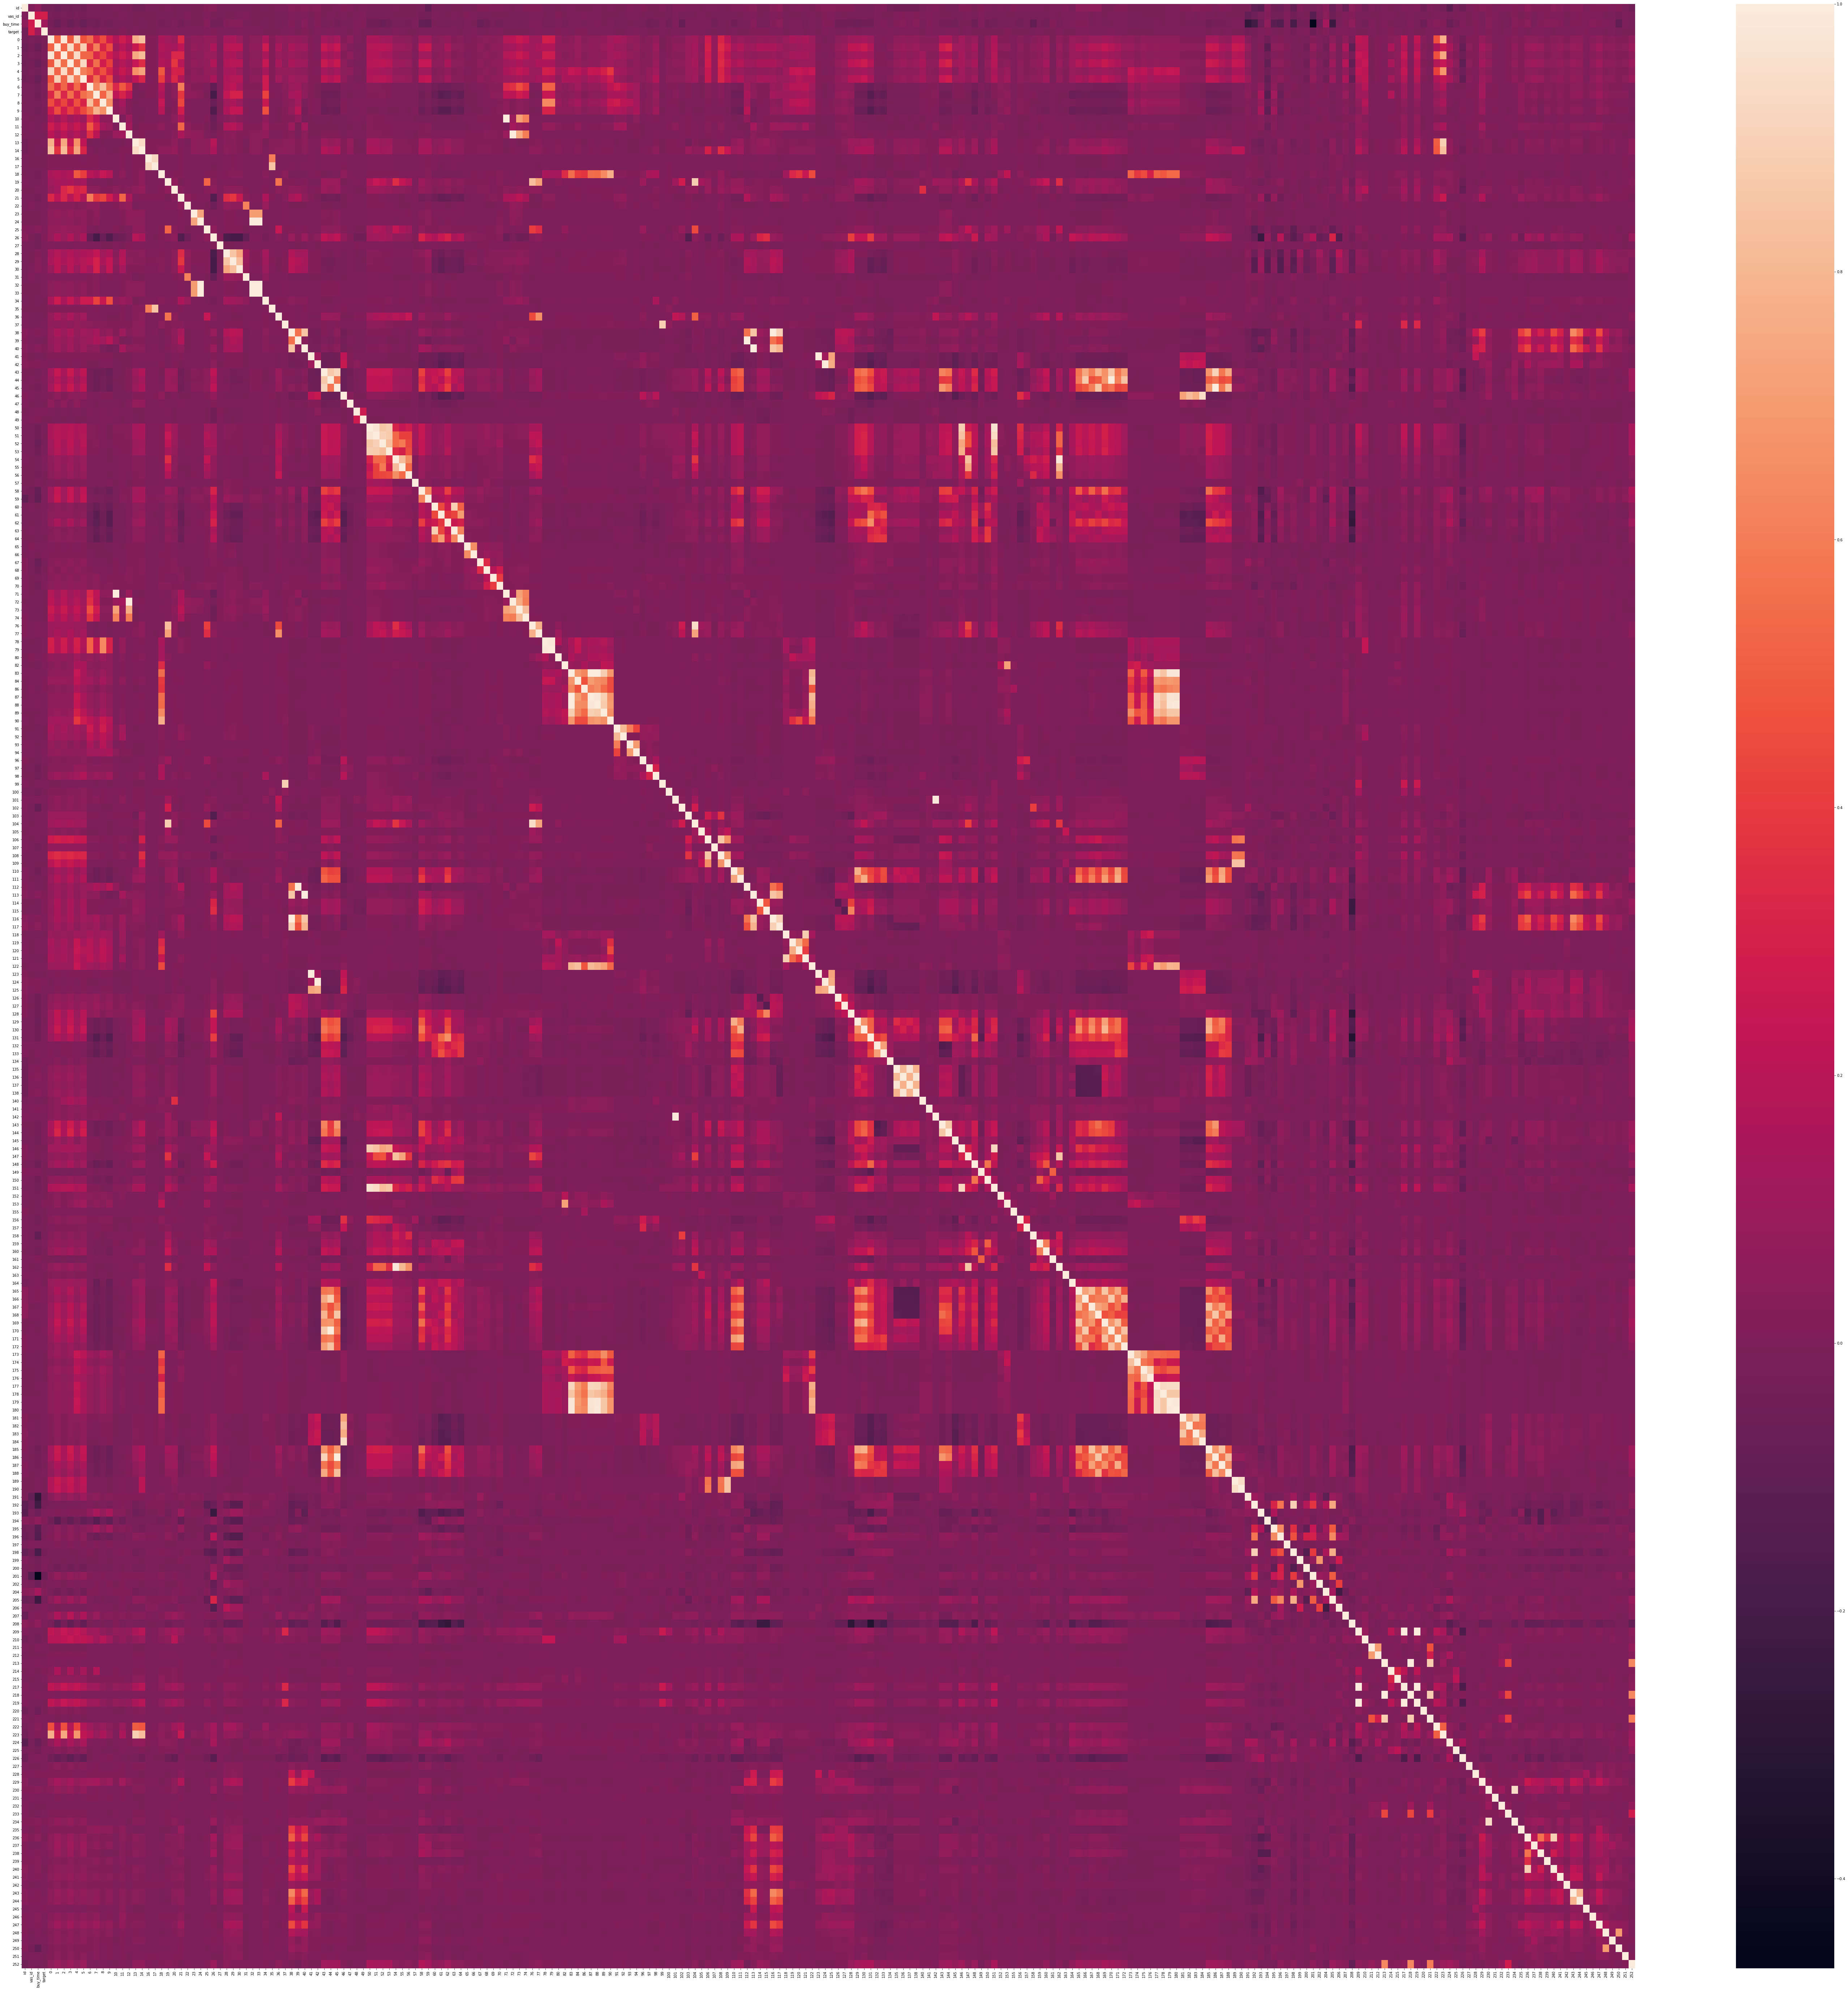

In [271]:
plt, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(data_corr,ax=ax)

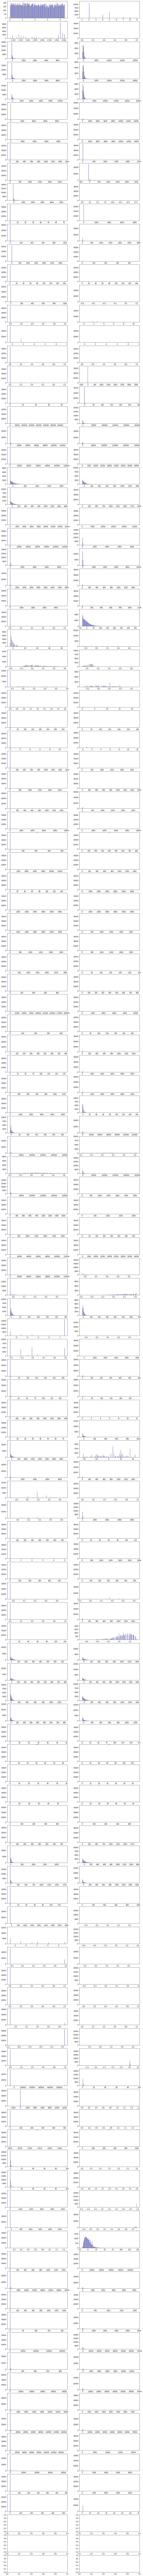

In [272]:
# гистограммы распределения признаков:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(127, 2, figsize=(15, 300))

for num, feature in enumerate(data_.columns.tolist()):
    data__ = data_[feature].copy()
    axes[num//2, num%2].hist(data__, bins=200, color="blue", ec='white')
    axes[num//2, num%2].set_xlabel(feature, fontsize=10)

ValueError: If using all scalar values, you must pass an index

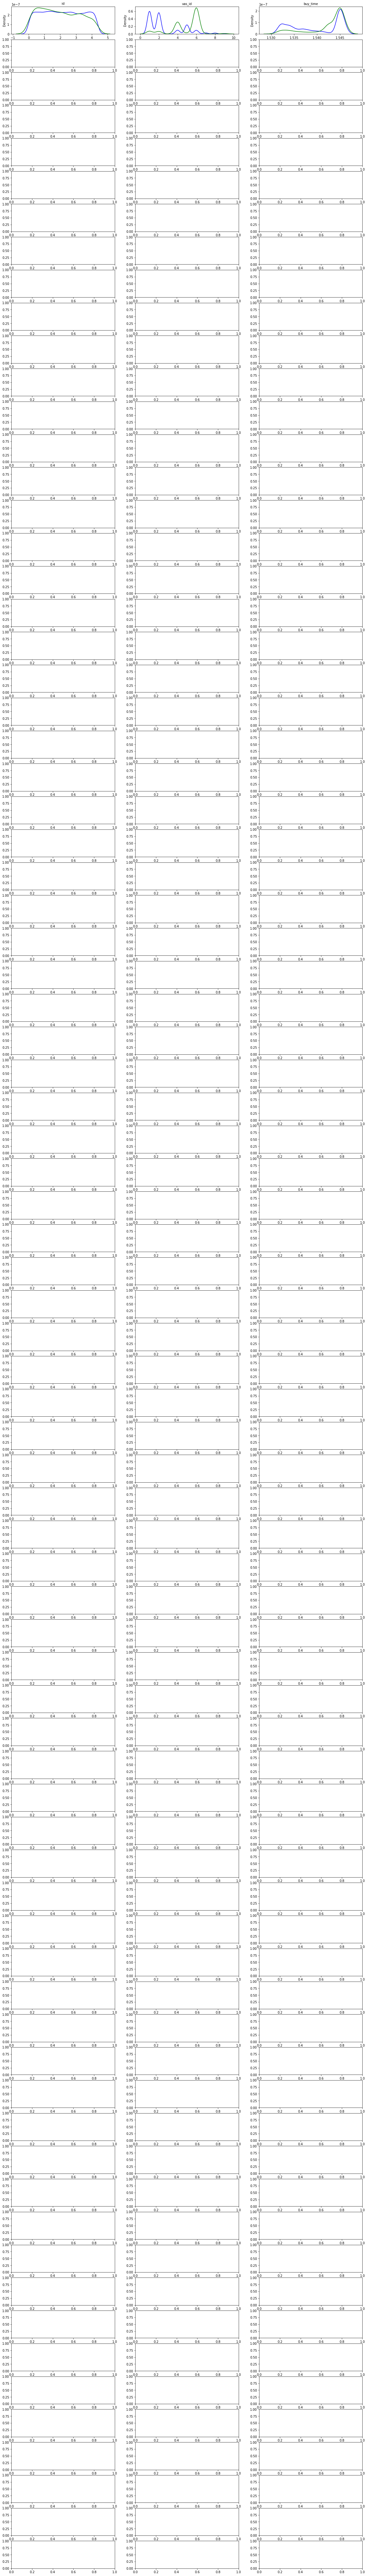

In [280]:
# посмотрим разрешающую способность фич в зависимости от цели (0 или 1)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(78, 3, figsize=(20, 150))
for num, feature in enumerate(data_.columns.tolist()):
    try:
        feature_with_target_s = data_[[feature, 'target']]
        feature_s = feature_with_target_s[feature]
        feature_target_0 = feature_s[feature_with_target_s['target'] == 0]
        feature_target_1 = feature_s[feature_with_target_s['target'] == 1]
        sns.kdeplot(feature_target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(feature_target_1, ax=axes[num//3, num%3], color="green", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        sns.kdeplot(feature_target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(feature_target_1, ax=axes[num//3, num%3], color="green", label="target=1")
    axes[num//3, num%3].set_title(feature, fontsize=10) 

### Везде, кроме 

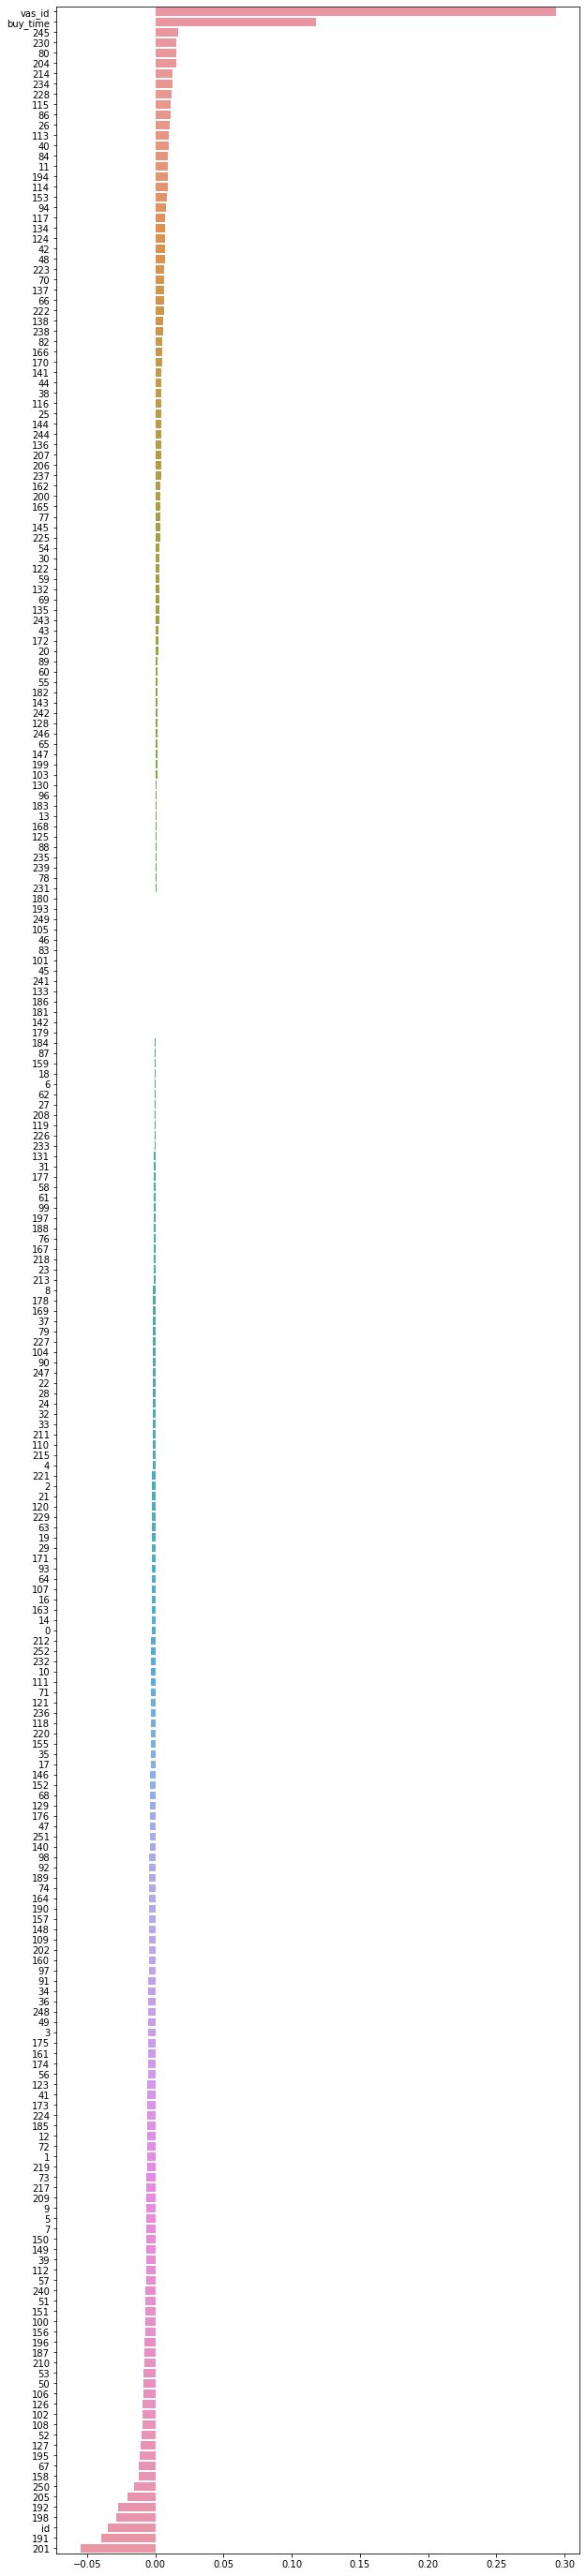

In [281]:
# получим корреляцию признаков с целью, запишем в Сириес, отсортируем в порядке убывания
import matplotlib.pyplot as plt
series_corr_with_target = data_[data_.columns.drop('target').tolist() + ['target']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt, ax = plt.subplots(figsize=(10, 50))
sns.barplot(x=series_corr_with_target.values, y=series_corr_with_target.index)
plt.show()

In [291]:
# получили множество фич, где корреляция с целью, больше по модулю 0.001, запишем это в множество
ser_corr_with_target = series_corr_with_target[abs(series_corr_with_target) > 0.005 ]
set_corr_with_target = set(ser_corr_with_target.index)
len(set_corr_with_target)

88

In [292]:
# Произведём оценку признаков по методике WOE/IV, выведем IV данные по фичам в отсортированном виде,
data__ = data_.drop(['target'], axis = 1)
y_ = data_['target']
final_iv, IV = data_vars(data__, y_)
df_iv_selected = IV.sort_values('IV')
df_iv_selected

VAR_NAME            IV
125       214  0.000000e+00
128       218  9.431582e-10
141        23  9.431582e-10
152        24  3.772691e-09
175        33  3.772691e-09
..        ...           ...
100       191  3.033497e-02
112       201  6.670988e-02
164       250  6.958096e-02
244  buy_time  3.421116e-01
246    vas_id  1.653166e+00

[247 rows x 2 columns]

In [294]:
set_iv_selected = set(df_iv_selected['VAR_NAME'].tail(100).tolist())

In [293]:
# получение объединённого множества фич после корреляции с целью и IV метода
set_feature_selected = set_corr_with_target | set_iv_selected
len(set_feature_selected)

137

In [299]:
f_all = set(data_.columns.tolist())

In [300]:
f_to_drop = f_all - set_feature_selected

In [301]:
data_tr = data_.drop(f_to_drop, axis =1)

In [302]:
data_tr

id  vas_id    buy_time           1           3          5  \
0            2     2.0  1545598800  229.530888  305.723202  284.61821   
1          389     2.0  1544994000   94.350888   58.693202   37.58821   
2          620     1.0  1537736400 -320.009112 -372.616798 -393.72179   
3          633     2.0  1544994000 -332.789112 -359.966798 -381.07179   
4          665     6.0  1543179600 -408.179112 -460.786798 -481.89179   
...        ...     ...         ...         ...         ...        ...   
34938  4362086     5.0  1544994000  -73.089112  -90.136798 -111.24179   
34939  4362329     2.0  1544389200  -87.299112 -120.426798 -141.53179   
34940  4362363     2.0  1546203600 -370.039112 -418.406798 -439.51179   
34941  4362540     6.0  1544994000 -181.049112 -191.296798 -212.40179   
34942  4362640     2.0  1546203600  -66.149112 -107.776798 -128.88179   

              6          7        8          9        10        11        12  \
0     -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   
1      -3.36618  15.483903 -6.70814 -25.810938 -2.736081  8.636954 -2.558912   
2     -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   
3     -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   
4     -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   
...         ...        ...      ...        ...       ...       ...       ...   
34938 -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   
34939 -16.08618 -59.146097 -6.78366 -30.006493 -2.736081 -4.007526 -2.558912   
34940 -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   
34941 -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   
34942 -16.08618 -65.076097 -6.78366 -30.006538 -2.736081 -4.007526 -2.558912   

            18        19         20         21        25        26        29  \
0     -5.41746 -3.178521 -13.940815 -10.744164 -2.082209  0.200138 -0.214366   
1     -5.41746 -3.178521  -1.230815 -10.744164 -2.082209  0.200138 -0.214366   
2     -5.41746 -3.178521 -13.940815 -10.744164 -2.082209 -0.799862 -0.214366   
3     -5.41746 -3.178521  -9.700815 -10.744164 -2.082209 -0.799862 -0.214366   
4     -5.41746 -3.178521 -13.940815 -10.744164 -2.082209 -0.799862 -0.214366   
...        ...       ...        ...        ...       ...       ...       ...   
34938 -5.41746 -3.178521  -5.050815 -10.744164 -2.082209  0.200138 -0.214366   
34939 -5.41746 -3.178521  -5.050815 -10.744164 -2.082209  0.200138 -0.214366   
34940 -5.41746 -3.178521 -13.940815 -10.744164 -2.082209  0.200138 -0.214366   
34941 -5.41746 -3.178521  -8.860815 -10.744164 -2.082209  0.200138 -0.214366   
34942 -5.41746 -0.128521 -11.440815 -10.744164  0.967791  0.200138 -0.214366   

             34        36           39           40         41          42  \
0      -2.65939 -0.700765  3442.168763     6.464136 -89.504287 -119.724355   
1      10.06061 -0.700765 -1168.250212 -1104.348364 -89.504287 -119.724355   
2      -2.65939 -0.700765 -1186.765837 -1755.674564 -89.504287 -119.724355   
3      -2.65939 -0.700765 -1186.765837 -1755.674564 -89.504287 -119.724355   
4      -2.65939 -0.700765 -1186.765837 -1755.674564 -89.504287 -119.724355   
...         ...       ...          ...          ...        ...         ...   
34938  -2.65939 -0.700765 -1186.765837 -1755.674564 -89.504287 -119.724355   
34939  -2.65939 -0.700765 -1109.125212  1567.923136 -89.504287 -119.724355   
34940  -2.65939 -0.700765 -1186.765837 -1755.674564 -89.504287 -119.724355   
34941  -2.65939 -0.700765  1733.708763 -1755.674564 -89.504287 -119.724355   
34942  -2.65939 -0.700765 -1105.383027 -1748.661869 -89.504287 -119.724355   

              48         49         50         51         52         53  \
0     -10.717958 -28.571103   0.869716  -4.088986 -21.171711  12.668705   
1     -10.698969 -28.547005  49.869716  44.911014  18.828289  34.668705   
2     -10.717958 -28.571103 -28.130284 -33.088986 -

In [303]:
X_train, X_test, y_train, y_test = train_test_split(data_tr, y_, test_size=0.2, random_state=42, shuffle=True)

In [304]:
# функция кросс-валидации по метрики ROC-AUC с выдачей результатов
def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [305]:
kfold_cv = KFold(n_splits=4, shuffle=False, random_state=None) # разобьём на 4 фолда, не перемешивая

run_cv(rfc, kfold_cv, X_train, y_train, model_name="Baseline")

Baseline: roc_auc = 0.90 (+/- 0.02)


In [307]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)[:,1]

In [308]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred)

In [309]:
# функция постороения ROC кривой
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

In [315]:
y_pred_ = rfc.predict(X_test).astype(int)
print("f1_score: {}".format(f1_score((y_test), (y_pred_))))
print("precision: {}".format(precision_score((y_test), (y_pred_))))
print("recall: {}".format(recall_score((y_test), (y_pred_))))

f1_score: 0.10681399631675874
precision: 0.5370370370370371
recall: 0.05930470347648262


In [316]:
# функция постороения PR кривой
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

Вывод: классификатор запомнил кто из пользователей пользовался какими услугами и выдаёт довольно сносный прогноз

In [318]:
# функция вычисления матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

AttributeError: 'Figure' object has no attribute 'cm'

In [319]:
# TN, FP(Type II error)
# 
# FN(Type I error),  TP

cm = confusion_matrix(y_test, y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

NameError: name 'plot_confusion_matrix' is not defined

In [327]:
print(classification_report(y_test, y_pred > 0.3))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      6500
         1.0       0.45      0.46      0.46       489

    accuracy                           0.92      6989
   macro avg       0.70      0.71      0.71      6989
weighted avg       0.92      0.92      0.92      6989

